# Project overview

- Problem : Companies advertise online, click fraud can haapen.
    - Resulting in misleading click data and wasted money.
    - 3 billion clicks per day, of which 90% are potentially fradulent.
- Current Solution : measure the journey of a user's click across their portfolio, and flag IP addresses who produce lots of clicks. 
    - build IP blacklist and device blacklist.
- Challenge : build an algorithm that predicts whether a user will download an app after clicking a mobile app ad.

#### Goal : predict if a person after clicking a mobile app advertisement will download the app. The data is highly unbalanced with only 0.25% data of positive class.

## Hypothesis Framework

#### Current Hypothesis 
- __Hypothesis__ : IPs having % of Fradulent downloads = 100 % are possibly fradulent.
- __Prescriptive Action__ : Block the IPs
<br/><br/>
- __Hypothesis__ : IPs having % of Fradulent downloads > 80% are possibly fradulent.
- __Prescriptive Action__ : Temporarly hold the payment for the ad click and not charge the APP and investigate further, Block the IP
<br/><br/>

#### Big Hypothesis 
- __Hypothesis__ : Predict the likelihood of a click from an app being fradulent using the best predictive model
- __Prescriptive Action__ : If Likelyhood > Threshold 1 - Block the IPs
<br/><br/>
- __Hypothesis__ : Predict the likelihood of a click from an app being fradulent using the best predictive model developed in Kaggle. 
- __Prescriptive Action__ : If Likelyhood > Threshold 2. Temporarily hold the payment for the ad click and not charge the APP and investigate further 
- __What not to do yet__ : - Block the IP
<br/>

> __Talking Data can use the Fraud Detection predictive model to either blacklist the IPs, Apps,Devices or use the predictive model in real-time to prevent fraud when the transaction happens.__



#### Project Hypothesis 
- __Hypothesis__ : Predict the likelihood of a click from an app being fradulent using the best predictive model
- __Prescriptive Action__ : If Likelyhood > Threshold 1 - Block the IPs
<br/><br/>
- __Hypothesis__ : Predict the likelihood of a click from an app being fradulent using the best predictive model developed in Kaggle. If Likelyhood > Threshold 2
- __Prescriptive Action__ : Temporarily hold the payment for the ad click and not charge the APP and investigate further 
- __What not to do yet__ : - Block the IP
<br/>

In [266]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
%matplotlib inline
import time
from subprocess import check_output
path = '../../../DEVELOPMENT/Fraud Detection/input/'
import gc


from sklearn.linear_model import LogisticRegression
from scipy.special import expit, logit
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix

In [267]:
data = pd.read_csv('../../../DEVELOPMENT/Fraud Detection/input/train_sample.csv',parse_dates=['click_time'])
data.dtypes

ip                          int64
app                         int64
device                      int64
os                          int64
channel                     int64
click_time         datetime64[ns]
attributed_time            object
is_attributed               int64
dtype: object

In [273]:
def prep_data(d):
    d['hour'] = pd.to_datetime(d.click_time).dt.hour.astype('uint8')
    d['day'] = pd.to_datetime(d.click_time).dt.day.astype('uint8')
    d['wday']  = pd.to_datetime(d.click_time).dt.dayofweek.astype('uint8')

    print('hour/download combination')
    gp = d.groupby('hour', as_index = False).count()
    gp = d[['hour', 'app', 'attributed_time']].groupby(by='hour').count().reset_index()
    gp = gp.rename(columns = {'app': 'click_count', 'attributed_time': 'download_count'})
    gp['h_download_rate'] = gp['download_count'] / gp['click_count'] * 100
    d = d.merge(gp[['hour','h_download_rate']], on='hour' ,how='left')
    del gp; gc.collect()

    print('ip/download combination')
    gp = d.groupby('ip', as_index = False).count()
    gp = d[['hour', 'app', 'attributed_time']].groupby(by='hour').count().reset_index()
    gp = gp.rename(columns = {'app': 'click_count', 'attributed_time': 'download_count'})
    gp['h_download_rate'] = gp['download_count'] / gp['click_count'] * 100
    d = d.merge(gp[['hour','h_download_rate']], on='hour' ,how='left')
    del gp; gc.collect()

    gp = d.groupby('hour', as_index = False).count()
    gp = d[['hour', 'app', 'attributed_time']].groupby(by='hour').count().reset_index()
    gp = gp.rename(columns = {'app': 'click_count', 'attributed_time': 'download_count'})
    gp['h_download_rate'] = gp['download_count'] / gp['click_count'] * 100
    d = d.merge(gp[['hour','h_download_rate']], on='hour' ,how='left')
    del gp; gc.collect()
    
    gp = d.groupby('hour', as_index = False).count()
    gp = d[['hour', 'app', 'attributed_time']].groupby(by='hour').count().reset_index()
    gp = gp.rename(columns = {'app': 'click_count', 'attributed_time': 'download_count'})
    gp['h_download_rate'] = gp['download_count'] / gp['click_count'] * 100
    d = d.merge(gp[['hour','h_download_rate']], on='hour' ,how='left')
    del gp; gc.collect()
        
    return d

In [258]:
#Change data types
data['day'] = data['click_time'].dt.day.astype('uint8')
data['hour'] = data['click_time'].dt.hour.astype('uint8')
data['minute'] = data['click_time'].dt.minute.astype('uint8')
data['second'] = data['click_time'].dt.second.astype('uint8')
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,0,9


In [259]:
# Change time
data['click_time_dt']= pd.to_datetime(data['click_time'])
dt= data['click_time_dt'].dt
data['day'] = dt.day.astype('uint8')
data['hour'] = dt.hour.astype('uint8')
data['minute'] = dt.minute.astype('uint8')

In [260]:
count_per_hour = data.groupby('hour', as_index = False).count()
count_per_hour.head()

,hour,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,minute,second,click_time_dt
0,0,5654,5654,5654,5654,5654,5654,13,5654,5654,5654,5654,5654
1,1,5103,5103,5103,5103,5103,5103,15,5103,5103,5103,5103,5103
2,2,5137,5137,5137,5137,5137,5137,10,5137,5137,5137,5137,5137
3,3,5264,5264,5264,5264,5264,5264,15,5264,5264,5264,5264,5264
4,4,6039,6039,6039,6039,6039,6039,10,6039,6039,6039,6039,6039


In [261]:
count_per_hour = count_per_hour[['hour', 'app', 'attributed_time']]
count_per_hour.head()

,hour,app,attributed_time
0,0,5654,13
1,1,5103,15
2,2,5137,10
3,3,5264,15
4,4,6039,10


In [209]:
count_per_hour = count_per_hour.rename(columns = {'app': 'click_count', 'attributed_time': 'download_count'})
count_per_hour['download_rate'] = count_per_hour['download_count'] / count_per_hour['click_count'] * 100
count_per_hour.head()

,hour,click_count,download_count,download_rate
0,0,5654,13,0.230
1,1,5103,15,0.294
2,2,5137,10,0.195
3,3,5264,15,0.285
4,4,6039,10,0.166


In [210]:
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,click_time_dt
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,30,38,2017-11-07 09:30:38
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,40,27,2017-11-07 13:40:27
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,5,24,2017-11-07 18:05:24
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,58,8,2017-11-07 04:58:08
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,0,9,2017-11-09 09:00:09


In [211]:
#What I cannot find meaningful result
data = data.drop('click_time_dt', axis = 1)

In [212]:
count_per_hour = data.groupby('hour', as_index = False).count()
count_per_hour.head()

,hour,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,minute,second
0,0,5654,5654,5654,5654,5654,5654,13,5654,5654,5654,5654
1,1,5103,5103,5103,5103,5103,5103,15,5103,5103,5103,5103
2,2,5137,5137,5137,5137,5137,5137,10,5137,5137,5137,5137
3,3,5264,5264,5264,5264,5264,5264,15,5264,5264,5264,5264
4,4,6039,6039,6039,6039,6039,6039,10,6039,6039,6039,6039


In [213]:
gp = data[['hour', 'app', 'attributed_time']].groupby(by='hour').count().reset_index()
gp.head()

,hour,app,attributed_time
0,0,5654,13
1,1,5103,15
2,2,5137,10
3,3,5264,15
4,4,6039,10


In [214]:
gp = gp.rename(columns = {'app': 'click_count', 'attributed_time': 'download_count'})
gp['h_download_rate'] = gp['download_count'] / gp['click_count'] * 100
gp.head()

,hour,click_count,download_count,h_download_rate
0,0,5654,13,0.230
1,1,5103,15,0.294
2,2,5137,10,0.195
3,3,5264,15,0.285
4,4,6039,10,0.166


In [215]:
click_ip_count = data.groupby('ip', as_index= False)['device'].aggregate('count').sort_values('device', ascending=False)
click_ip_count = click_ip_count.rename(columns={'device':'count'})
click_ip_count.head()

,ip,count
926,5348,669
918,5314,616
12833,73487,439
12839,73516,399
9385,53454,280


In [216]:
ip_click_ranking = data.groupby('ip', as_index = False).count().sort_values(by = 'app', ascending=False)
ip_click_ranking = ip_click_ranking[['ip', 'app']]
ip_click_ranking = ip_click_ranking.rename(columns={'app':'click_count'})
ip_click_ranking.head(10)

,ip,click_count
926,5348,669
918,5314,616
12833,73487,439
12839,73516,399
9385,53454,280
20021,114276,219
4639,26995,218
16703,95766,205
2990,17149,186
17488,100275,173


In [217]:
ip_click_download = data.groupby('ip', as_index = False).sum().sort_values(by='app', ascending = False).reset_index()
ip_click_download = ip_click_download[['ip', 'app', 'is_attributed']]
ip_click_download = ip_click_download.rename(columns={'is_attributed': 'download_count', 'app': 'click_count'})

ip_click_download.head()

,ip,click_count,download_count
0,5314,10086,3
1,5348,9478,3
2,73487,4809,0
3,73516,4428,0
4,53454,3548,0


In [218]:
ip_click_download['i_download_rate'] = ip_click_download['download_count'] / ip_click_download['click_count'] * 100
ip_click_download.head()

,ip,click_count,download_count,i_download_rate
0,5314,10086,3,0.030
1,5348,9478,3,0.032
2,73487,4809,0,0.000
3,73516,4428,0,0.000
4,53454,3548,0,0.000


In [231]:
data = data.merge(ip_click_download[['ip','i_download_rate']], on='ip' ,how='left')

In [219]:
dll_cnt_device = data.groupby('device', as_index=False).sum().sort_values(by='is_attributed', ascending=False)
dll_cnt_device = dll_cnt_device[['device', 'is_attributed']]
dll_cnt_device = dll_cnt_device.rename(columns={'is_attributed': 'download_count'})
dll_cnt_device.head()

,device,download_count
1,1,146
0,0,52
32,97,3
9,16,3
13,21,2


In [220]:
click_cnt_device = data.groupby('device', as_index=False).count().sort_values(by='app', ascending=False)
click_cnt_device = click_cnt_device[['device', 'app']]
click_cnt_device = click_cnt_device.rename(columns={'app': 'click_count'})
click_cnt_device.head()

,device,click_count
1,1,94338
2,2,4345
0,0,541
93,3032,371
96,3543,151


In [221]:
device_click_download_df = pd.merge(click_cnt_device, dll_cnt_device, on='device') 
device_click_download_df['d_download_rate'] = device_click_download_df['download_count']/ device_click_download_df['click_count'] * 100 
device_click_download_df.head()

,device,click_count,download_count,d_download_rate
0,1,94338,146,0.155
1,2,4345,2,0.046
2,0,541,52,9.612
3,3032,371,0,0.000
4,3543,151,0,0.000


In [232]:
data = data.merge(device_click_download_df[['device','d_download_rate']], on='device' ,how='left')

In [233]:
dll_cnt_os = data.groupby('os', as_index=False).sum().sort_values(by='is_attributed', ascending=False)
dll_cnt_os = dll_cnt_os[['os', 'is_attributed']]
dll_cnt_os = dll_cnt_os.rename(columns={'is_attributed': 'download_count'})
dll_cnt_os.head()

,os,download_count
19,19,41
0,0,26
24,24,26
13,13,25
29,29,11


In [234]:
click_cnt_os = data.groupby('os', as_index=False).count().sort_values(by='app', ascending=False)
click_cnt_os = click_cnt_os[['os', 'app']]
click_cnt_os = click_cnt_os.rename(columns={'app': 'click_count'})
click_cnt_os.head()

,os,click_count
19,19,23870
13,13,21223
17,17,5232
18,18,4830
22,22,4039


In [235]:
os_click_download_df = pd.merge(click_cnt_os, dll_cnt_os, on='os') 
os_click_download_df['o_download_rate'] = os_click_download_df['download_count']/ os_click_download_df['click_count'] * 100 
os_click_download_df.head()

,os,click_count,download_count,o_download_rate
0,19,23870,41,0.172
1,13,21223,25,0.118
2,17,5232,6,0.115
3,18,4830,4,0.083
4,22,4039,6,0.149


In [236]:
data = data.merge(os_click_download_df[['os','o_download_rate']], on='os' ,how='left')

In [242]:
click_ip_count = data.groupby('app', as_index= False)['device'].aggregate('count').sort_values('device', ascending=False)
click_ip_count = click_ip_count.rename(columns={'device':'click_count'})
click_ip_count = click_ip_count[click_ip_count['click_count'] > 100]
click_ip_count.head()

,app,click_count
2,3,18279
11,12,13198
1,2,11737
8,9,8992
14,15,8595


In [238]:
click_cnt_channel = data.groupby('channel', as_index=False).count().sort_values(by='app', ascending=False)
click_cnt_channel = click_cnt_channel[['channel', 'app']]
click_cnt_channel = click_cnt_channel.rename(columns={'app': 'click_count'})

click_cnt_channel.head()

,channel,click_count
77,280,8114
64,245,4802
14,107,4543
146,477,3960
33,134,3224


In [239]:
channel_click_download_df = pd.merge(click_cnt_channel, dll_cnt_channel, on='channel') 
channel_click_download_df['c_download_rate'] = channel_click_download_df['download_count']/ channel_click_download_df['click_count'] * 100 
channel_click_download_df.head(10)

,channel,click_count,download_count,c_download_rate
0,280,8114,2,0.025
1,245,4802,0,0.000
2,107,4543,1,0.022
3,477,3960,0,0.000
4,134,3224,1,0.031
5,259,3130,0,0.000
6,265,3013,2,0.066
7,153,2954,0,0.000
8,178,2936,0,0.000
9,121,2472,1,0.040


In [240]:
data = data.merge(channel_click_download_df[['channel','c_download_rate']], on='channel' ,how='left')

In [241]:
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,i_download_rate,d_download_rate,o_download_rate,c_download_rate
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,30,38,0.000,0.155,0.118,0.000
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,40,27,0.000,0.155,0.115,0.000
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,5,24,0.000,0.155,0.172,0.000
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,58,8,0.000,0.155,0.118,0.000
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,0,9,0.000,0.155,0.084,0.000


In [243]:
data = data.drop(['click_time','attributed_time'], axis=1)

In [245]:
data.tail()

,ip,app,device,os,channel,is_attributed,day,hour,minute,second,i_download_rate,d_download_rate,o_download_rate,c_download_rate
99995,124883,11,1,19,122,0,9,13,25,41,0.000,0.155,0.172,0.000
99996,85150,9,1,13,244,0,7,11,25,43,0.000,0.155,0.118,0.000
99997,18839,3,1,13,19,0,8,11,38,42,0.000,0.155,0.118,0.000
99998,114276,15,1,12,245,0,8,17,55,21,0.000,0.155,0.091,0.000
99999,119349,14,1,15,401,0,7,14,32,27,0.000,0.155,0.167,0.000


In [244]:
RANDOM_SEED = 1
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

X_train, X_test = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)

y_train = X_train['is_attributed']
X_train = X_train.drop(['is_attributed'], axis=1)
y_test = X_test['is_attributed']
X_test = X_test.drop(['is_attributed'], axis=1)

In [246]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=9, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [247]:
predictions = rf.predict_proba(X_test)
predictions

array([[  9.99967382e-01,   3.26180382e-05],
       [  9.99940097e-01,   5.99026760e-05],
       [  9.99828313e-01,   1.71687022e-04],
       ..., 
       [  9.99980548e-01,   1.94519765e-05],
       [  9.99928462e-01,   7.15382224e-05],
       [  9.99946282e-01,   5.37177568e-05]])

In [248]:
def convert_preds(raw_preds):
    preds = []
    for p in raw_preds:
        preds.append(1 - p[0])
    return preds

In [249]:
val_preds = convert_preds(predictions)

In [250]:
max(val_preds)

1.0

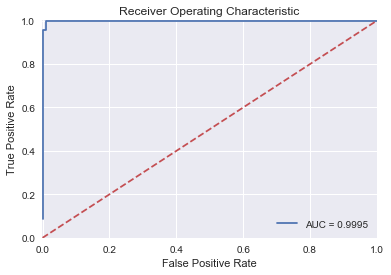

In [251]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(y_test, val_preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [255]:
test = pd.read_csv(path+'test.csv')